In [ ]:
#supposed the input is in df, the data of X_test=['อย่า ลืม ติดตาม ชม รายการ พิเศษ','ด่วน ลด แบบ จัดเต็ม ของแถม มากมาย']
#keras embed method, will update with the tokenizer and weight file
#python3.9 keras3.01

In [1]:
import re
import pandas as pd
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import Model #new 3 
from sklearn.svm import SVC #new 3 
import joblib #new 3


In [126]:
def load_model(file,weight_file): #new
    with open(file, "r") as json_file:
        loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    model.load_weights(weight_file) 
    return model

def preproces_df1(df): #new 2
    df_a = df
    df_a['split_text'] = df_a.apply(lambda row: word_tokenize(row['tweet_text'],engine="newmm",keep_whitespace=False), axis=1) #use this
    df_a['combined'] = [' '.join(lst) for lst in df_a['split_text']]
    df_a['cleaned'] = df_a['combined'].apply(deEmojify)
    df_a['cleaned'] = df_a['cleaned'].apply(stopwords_rm) 
    df_a['cleaned'] = alone(df_a) #new
    df_a['split_cleaned'] = df_a.apply(lambda row: word_tokenize(row['cleaned'],engine="newmm",keep_whitespace=False), axis=1)
    #df_a['word_length'] = df_a['split_cleaned'].str.len()
    df_a = df_a.dropna(subset=['tweet_text']) #new

    return df_a

def preproces_df(csv):
    #preprocessing the data from df 
    df_a = pd.read_csv(csv)
    df_a = preproces_df1(df_a) #new 2

    df_a['contain_area'],df_a['contain_good'] = '2','2' #new -holder new column
    for i in range(df_a['split_cleaned'].shape[0]):  #new
        if 'ดี' in df_a['split_cleaned'].iloc[i]: 
            df_a['contain_good'].iloc[i] = '1'
        else:
            df_a['contain_good'].iloc[i] = '0'

    for i in range(df_a['split_cleaned'].shape[0]): #new
        if 'พื้นที่' in df_a['split_cleaned'].iloc[i]:
            df_a['contain_area'].iloc[i] = '1'
        else:
            df_a['contain_area'].iloc[i] = '0'

    return df_a

#loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#sub function below---------------------------------------------------------------------------------------------------
def stopwords_rm(text):
    stopwords = set(thai_stopwords())
    stopwords.update(["nan", "-", "_", "", " ", "฿" ,"ค่ะ", "ครับ", "จ้า"])  # Add more stopwords as needed

    # Remove stopwords from the text
    cleaned_text = ' '.join(word for word in text.split() if word not in stopwords)
    return cleaned_text

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def alone(df):
    print('Are you alone?')
    i = 0 #row number
    df['cleaned1'] = ''
    for row in df['cleaned']:
        words = row.split() #j is array of string
        cleaned = [word for word in words if len(word) > 1]
        cleaned_string = " ".join(cleaned)
        df['cleaned1'].iloc[i] = cleaned_string
        i += 1
    print('done cleaning alone')
    return df['cleaned1']

def pau_anal(df_a): #new - do all the df
    contain_good = df_a['contain_good'].to_numpy()
    good_reshaped = np.reshape(contain_good, (contain_good.shape[0], 1))
    good_reshaped = [int(x) for n in range(int(df_a.shape[0]))for x in good_reshaped[n][0]] #list in int 
    np_good = np.array(good_reshaped)
    good_reshaped = np.reshape(np_good, (np_good.shape[0], 1))

    contain_area = (df_a['contain_area']).to_numpy()
    area_reshaped = np.reshape(contain_area, (contain_area.shape[0], 1))
    area_reshaped = [int(x) for n in range(int(df_a.shape[0]))for x in area_reshaped[n][0]] #list in int 
    np_area = np.array(area_reshaped)
    area_reshaped = np.reshape(np_good, (np_good.shape[0], 1))
    return good_reshaped, area_reshaped


# Load model and weight
def Main(df):
    model = load_model("./org_model_architecture.json", "./org_model_weights.h5") #new
    df_1 = preproces_df1(df) #new 2
    df = df_1 #new 2 
    print('predicting...')
    MAX_SEQUENCE_LENGTH = 63 #training file 44
    MAX_WORDS = 2500 #2000

    tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
    tokenizer.fit_on_texts(df.cleaned.values)
    #X_test=[df['cleaned']] #new 2 
    X_test=tokenizer.texts_to_sequences(df.cleaned.values) #new 2 
    print('shit1', len(X_test))
    X_test=pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(X_test)
    org = ['public work (โยธา)', 'municipal office (เทศกิจ)' ,'police department']
    pred_org = np.round(predictions)#new2
    pred_org = pred_org.astype(int) #new2

    
    print('result int: ', pred_org) #new2
    org_result = [org[i[0]] for i in pred_org] #new2
    print('classs predicted: ', org_result) #new2
    print('confidence %:', predictions) #new2
    #for checking from ori excel
    #print('real cat is : ',df['org'].iloc[-1])
    if 'org' not in df.index:
        df['org'] = ''   #make column in df
    df['org'] = org_result
    return df

def Main_relevant(df):
    model = load_model("./model/relevant_arch_hyper.json", "./model/relevant_weight_hyper.h5")#new this one old->./relevant_model_architecture.json
    df_1 = preproces_df(df) #new 2 df['tweet_text'] เป็นstring ของ tweet 
    df = df_1 #new 2
    print('predicting...')

    MAX_SEQUENCE_LENGTH = 132 #new
    MAX_WORDS = 3500 #new

    tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
    tokenizer.fit_on_texts(df.cleaned.values)
    word_index = tokenizer.word_index #new

    X = tokenizer.texts_to_sequences(df.cleaned.values) #new2
    print('X 2 ', X)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #new
    print('X 3 ', X)
    good_reshaped, area_reshaped = pau_anal(df) #new - adding pau good, area
    # Use np.hstack to append new column to the right

    X = np.hstack((X, good_reshaped)) #new
    X = np.hstack((X, area_reshaped)) #new
    X_test = X #new
    #X_test=[df['cleaned'].iloc[-1]] #new- delete
    #X_test=tokenizer.texts_to_sequences(X_test) #new- delete
    #X_test=pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH) #new- delete
    predictions = model.predict(X_test) #new 3 
    print(predictions)
    '''feature_extraction_model = Model(inputs=model.input, outputs=model.layers[-3].output) #new 3
    features = feature_extraction_model.predict(X_test) #new 3
  
    loaded_model = joblib.load('./model/svc_model.pkl') #new 3
    print(features.shape, 'feature shape ')
    predictions = loaded_model.predict(features)'''    #new 3


    rev = ['relevant','not relevant'] #swapping prediction here 

    print('result:', predictions)
    print('shape', predictions.shape)
    print('shape', type(predictions))
    pred_int = np.round(predictions) #new2
    pred_int  = pred_int.astype(int) #new2
    print('nahhhhhh ar', pred_int)
    print('nuh uh  ar', pred_int[0])

    #class_pred = [rev[i] for i in pred_int]#if use svc
    class_pred = [rev[i[0]] for i in pred_int]
    print('classs predicted: ', class_pred)
    print('confidence %: ', predictions)
    #for checking
    #print('real cat is : ',df['rev'])
    print('big prediction', predictions.shape)
    print('big dick', df.shape)

    if 'relevant_pred' not in df.index: #new 2
        df['relevant_pred'] = ''  #make column in df

    df['relevant_pred'] = class_pred #new 2

    df_new = df[df['relevant_pred'] != 'not relevant'] #new 2 drop
    return df_new, df


In [ ]:
df = Main(df_updated)

In [127]:
df_updated, df_drop = Main_relevant("./test_run.csv") #input the df location
#test_run.csv
#df_y4s2_final_new.csv

Are you alone?


C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned1'].iloc[i] = cleaned_string
C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned1'].iloc[i] = cleaned_string
C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned1'].iloc[i] 

done cleaning alone


C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['contain_good'].iloc[i] = '0'
C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['contain_good'].iloc[i] = '0'
C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['contain_good'].iloc[i] = '0

predicting...
X 2  [[1, 196, 111, 44, 302, 30, 601, 98, 119, 602, 26, 264, 79, 4, 112, 265, 34, 40, 303, 1577, 3, 112, 603, 5, 148, 1578, 17, 491, 265, 32], [1, 399, 1019, 1579, 50, 234, 604, 605, 73, 266, 25, 1, 267, 45, 53, 67, 1020, 1021, 1022, 492, 41, 493, 3, 345, 346], [1, 68, 347, 348, 197, 1, 268, 2, 21, 209, 494, 149, 349, 175, 350, 1023, 235, 1580, 759], [1024, 1, 1581, 1025, 1582, 1026, 150, 113, 1, 80, 68, 1, 197, 1027, 606, 1583, 150, 1584, 73, 1028, 760, 1029, 1, 41, 1585, 1030, 4, 1586, 210, 134, 268, 21, 209], [46, 23, 1, 11, 3, 400, 55, 1031, 134, 21, 1032, 761, 149, 86, 401, 1587, 134, 402, 4, 1588, 1589, 162, 3, 46, 23, 9, 351, 403, 607, 762], [1033, 1034, 69, 99, 4, 5, 347, 348, 763, 5, 234, 5, 1590, 1591, 151, 1592, 1035, 764, 1036, 352, 25, 1593, 1594, 152, 1595, 1596, 152, 11, 304, 495, 401, 211, 163, 100, 236, 1597], [28, 56, 1598, 62, 56, 22, 237, 1037, 12, 212, 403, 27, 2, 1599, 1038, 608, 609, 1039, 1600, 1040, 1601, 765, 12, 1041, 7, 15, 12, 12, 63, 610, 496

In [3]:
df_1 = pd.read_csv("./test_run.csv")
print(df_1['relevant'].value_counts())

In [128]:
df_drop

,index,username,tweet_id,tweet_text,translated_text,org_step_1,org_step_2,relevant,category,query,...,location,image,split_text,combined,cleaned,cleaned1,split_cleaned,contain_area,contain_good,relevant_pred
0,40.0,dohyunjinmin,1.723873e+18,เคยเดินจาก bts วัดพระศรีฯไปสายสีแดงหลักสี่ ระย...,Used to walk from BTS Wat Phra Si to the Laksi...,สนง.โยธา,สนง.โยธา,True,ทางเท้า,"(""ทางเท้า"" OR ""ทางเดิน"" OR ""ฟุตบาท"") AND (""ประ...",...,0.0,[],"[เคย, เดิน, จาก, bts, วัด, พระ, ศรี, ฯ, ไป, สา...",เคย เดิน จาก bts วัด พระ ศรี ฯ ไป สาย สีแดง หล...,เดิน bts วัด พระ ศรี สาย สีแดง หลัก สี่ ระยะทา...,เดิน bts วัด พระ ศรี สาย สีแดง หลัก สี่ ระยะทา...,"[เดิน, bts, วัด, พระ, ศรี, สาย, สีแดง, หลัก, ส...",0,0,not relevant
1,48.0,Simmons37496127,1.723770e+18,เคยเดินจากเซนทรัลลาดพร้าวไปพหลโยธิน 34 คือไม่...,I once walked from Central Ladprao to Phahon Y...,สนง.ตำรวจแห่งชาติ,สนง.ตำรวจแห่งชาติ,True,ทางเท้า,"(""ทางเท้า"" OR ""ทางเดิน"" OR ""ฟุตบาท"") AND (""กรุ...",...,NaN,[],"[เคย, เดิน, จาก, เซ, นท, รัล, ลาดพร้าว, ไป, พห...",เคย เดิน จาก เซ นท รัล ลาดพร้าว ไป พหลโยธิน 34...,เดิน เซ นท รัล ลาดพร้าว พหลโยธิน 34 ไหว พัง อา...,เดิน เซ นท รัล ลาดพร้าว พหลโยธิน 34 ไหว พัง อา...,"[เดิน, เซ, นท, รัล, ลาดพร้าว, พหลโยธิน, 34, ไห...",0,0,not relevant
2,56.0,xbiiryxxn,1.723708e+18,เคยเดินจากห้วยขวางไปสุทธิสาร สรุปเดินเหยียบฟุต...,Used to walk from Huai Khwang to Sutthisan. In...,สนง.โยธา,สนง.โยธา,True,ทางเท้า,"(""ทางเท้า"" OR ""ทางเดิน"" OR ""ฟุตบาท"") AND (""ห้ว...",...,NaN,[],"[เคย, เดิน, จาก, ห้วยขวาง, ไป, สุทธิ, สาร, สรุ...",เคย เดิน จาก ห้วยขวาง ไป สุทธิ สาร สรุป เดิน เ...,เดิน ห้วยขวาง สุทธิ สาร สรุป เดิน เหยียบ ฟุตบา...,เดิน ห้วยขวาง สุทธิ สาร สรุป เดิน เหยียบ ฟุตบา...,"[เดิน, ห้วยขวาง, สุทธิ, สาร, สรุป, เดิน, เหยีย...",0,0,relevant
3,62.0,BAROCTARISREAL,1.723677e+18,อยู่เกาหลีเดินสะบัด แดกเท่าไหรก็ นน ไม่ขึ้น กล...,"In Korea, I walked so hard, no matter how much...",สนง.โยธา,สนง.โยธา,True,ทางเท้า,"(""ทางเท้า"" OR ""ทางเดิน"" OR ""ฟุตบาท"") AND (""ห้ว...",...,NaN,[],"[อยู่, เกาหลี, เดิน, สะบัด, แดก, เท่า, ไห, ร, ...",อยู่ เกาหลี เดิน สะบัด แดก เท่า ไห ร ก็ นน ไม่...,เกาหลี เดิน สะบัด แดก ไห นน กลับมา ไทย เดิน พร...,เกาหลี เดิน สะบัด แดก ไห นน กลับมา ไทย เดิน พร...,"[เกาหลี, เดิน, สะบัด, แดก, ไห, นน, กลับมา, ไทย...",0,0,not relevant
4,68.0,ssssxsaii,1.723592e+18,บรรทัดทองจะน่าเดินกว่านี้ถ้า\n-ทำทางเดินใหม่ไม...,Banthat Thong would be more worth walking arou...,สนง.เทศกิจ,สนง.เทศกิจ,True,ทางเท้า,"(""ทางเท้า"" OR ""ทางเดิน"" OR ""ฟุตบาท"") AND (""นคร...",...,NaN,[],"[บรรทัด, ทอง, จะ, น่า, เดิน, กว่า, นี้, ถ้า, \...",บรรทัด ทอง จะ น่า เดิน กว่า นี้ ถ้า \n - ทำ ทา...,บรรทัด ทอง เดิน ทำ ทางเดิน แผ่น พื้น กระดก ท่อ...,บรรทัด ทอง เดิน ทำ ทางเดิน แผ่น พื้น กระดก ท่อ...,"[บรรทัด, ทอง, เดิน, ทำ, ทางเดิน, แผ่น, พื้น, ก...",0,0,not relevant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3529,3286.0,iamperrypp,1.610000e+18,แจ้งวัฒนะหน้าศูนย์ราชการแบบนี้เลย แต่ที่แย่กว่...,Chaengwattana in front of the government cente...,สนง.โยธา,สนง.โยธา,True,ทางเท้า,"(""ทางเท้า"" OR ""ทางเดิน"" OR ""ฟุตบาท"") AND (""เศร...",...,NaN,[],"[แจ้ง, วัฒนะ, หน้า, ศูนย์, ราชการ, แบบนี้, เลย...",แจ้ง วัฒนะ หน้า ศูนย์ ราชการ แบบนี้ เลย แต่ ที...,แจ้ง วัฒนะ หน้า ศูนย์ ราชการ แบบนี้ แย่ วิ่ง ฟ...,แจ้ง วัฒนะ หน้า ศูนย์ ราชการ แบบนี้ แย่ วิ่ง ฟ...,"[แจ้ง, วัฒนะ, หน้า, ศูนย์, ราชการ, แบบนี้, แย่...",0,0,relevant
3531,3288.0,jiwmallow,1.610000e+18,เห็นละนึกถึงวันนั้น กูเดินอยู่ทางเท้าแถวนวมินท...,I saw it and thought of that day. I'm walking ...,สนง.ตำรวจแห่งชาติ,สนง.ตำรวจแห่งชาติ,True,ทางเท้า,"(""ทางเท้า"" OR ""ทางเดิน"" OR ""ฟุตบาท"") AND (""นคร...",...,NaN,[],"[เห็น, ละ, นึกถึง, วันนั้น, กู, เดิน, อยู่, ทา...",เห็น ละ นึกถึง วันนั้น กู เดิน อยู่ ทางเท้า แถ...,นึกถึง เดิน ทางเท้า แถว นวมินทร์ 82 เดิน หอ อี...,นึกถึง เดิน ทางเท้า แถว นวมินทร์ 82 เดิน หอ อี...,"[นึกถึง, เดิน, ทางเท้า, แถว, นวมินทร์, 82, เดิ...",0,0,relevant
3539,3296.0,Ole53240,1.610000e+18,ทางเท้าถนนสีลมเพิ่งทำยังไม่เสร็จเรียบร้อยก็มีแ...,The sidewalk on Silom Road has just not been c...,สน

In [129]:
df_drop['relevant'].value_counts() 

relevant
True     271
False    271
Name: count, dtype: int64

In [130]:
df_drop['relevant_pred'].value_counts() 

relevant_pred
relevant        331
not relevant    211
Name: count, dtype: int64

## Evaluation of the relevance

In [131]:
df = df_drop
Y_test = df['relevant']
y_pred_binary = df['relevant_pred']
label_mapping1 = {False:0 , True: 1}
label_mapping2 = {'not relevant': 0, 'relevant': 1}
Y_test = Y_test.map(label_mapping1)
y_pred_binary = y_pred_binary.map(label_mapping2)

In [132]:
import numpy as np
from sklearn.metrics import log_loss, f1_score

'''y_pred_binary = y_pred_binary.astype(int)
Y_test = Y_test.astype(int)'''

loss = log_loss(Y_test, y_pred_binary, labels=[0, 1])
f1 = f1_score(Y_test, y_pred_binary)

print("Binary Cross-Entropy Loss:", loss)
print("F1 Score:", f1)

Binary Cross-Entropy Loss: 15.162274857414593
F1 Score: 0.6212624584717608


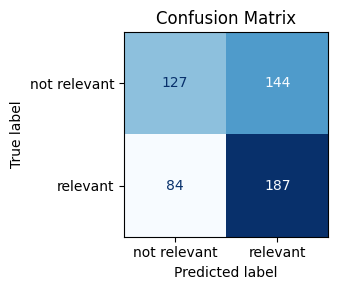

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(Y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not relevant', 'relevant'])
disp.plot(cmap=plt.cm.Blues, colorbar=False)
plt.title('Confusion Matrix')  # put title before to avoid cropping
plt.gcf().set_size_inches(4, 3)
plt.tight_layout()

# plt.savefig('./img/confusion_relevant_ori_trafbal_pauOLD.png') # Save the figure before showing
plt.show()


0      False
1      False
2      False
3      False
4      False
       ...  
546     True
547     True
548     True
549     True
550     True
Name: relevant, Length: 551, dtype: bool
[[132 148]
 [195  76]]


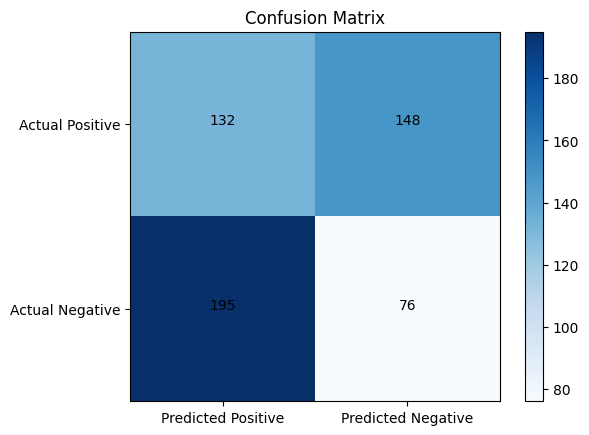

In [33]:
import matplotlib.pyplot as plt
import numpy as np
df = df_drop
True_pos = df[(df['relevant'] == True) & (df['relevant_pred'] == 'relevant')].shape[0]
True_neg = df[(df['relevant'] == False) & (df['relevant_pred'] == 'not relevant')].shape[0]
False_pos = df[(df['relevant'] == False) & (df['relevant_pred'] == 'relevant')].shape[0]
False_neg = df[(df['relevant'] == True) & (df['relevant_pred'] == 'not relevant')].shape[0]

confusion_matrix = np.array([[True_neg, False_pos],
                              [False_neg, True_pos]])

print(df['relevant'] == True)
print(confusion_matrix)
# Plot the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Set the axis labels
plt.xticks([0, 1], ['Predicted Positive', 'Predicted Negative'])
plt.yticks([0, 1], ['Actual Positive', 'Actual Negative'])

# Display the values in the matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment='center', color='black')

plt.show()



In [134]:
df = Main(df_updated)

C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['split_text'] = df_a.apply(lambda row: word_tokenize(row['tweet_text'],engine="newmm",keep_whitespace=False), axis=1) #use this
C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['combined'] = [' '.join(lst) for lst in df_a['split_text']]
C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:12: SettingWithCopyWarning: 

Are you alone?
done cleaning alone


C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['split_cleaned'] = df_a.apply(lambda row: word_tokenize(row['cleaned'],engine="newmm",keep_whitespace=False), axis=1)


predicting...
shit1 331
 6/11 [===============>..............] - ETA: 0s

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/embedding_1/embedding_lookup' defined at (most recent call last):
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue
      await self.process_one()
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 518, in process_one
      await dispatch(*args)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell
      await result
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 766, in execute_request
      reply_content = await reply_content
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\natkn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\3102576467.py", line 1, in <module>
      df = Main(df_updated)
    File "C:\Users\natkn\AppData\Local\Temp\ipykernel_20672\61220011.py", line 117, in Main
      predictions = model.predict(X_test)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\natkn\anaconda3\envs\gpt-twitter\lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_1/embedding_1/embedding_lookup'
indices[8,47] = 2000 is not in [0, 2000)
	 [[{{node sequential_1/embedding_1/embedding_lookup}}]] [Op:__inference_predict_function_66190]

In [ ]:
'''if df_drop[-1] == df_updated[-1]: #relevant
    df = Main(df_updated)
    print('relevant, updated')
    print('org is : ', )
else: 
    print('irrelevant, row deleted')
    print('deleted row : ', df_drop)''' 

In [34]:
df_drop.columns

Index(['index', 'username', 'tweet_id', 'tweet_text', 'org', 'relevant',
       'category', 'query', 'datetime_of_tweet', 'datetime_of_query', 'link',
       'mentioned_location', 'location', 'image', 'split_text', 'combined',
       'cleaned', 'cleaned1', 'split_cleaned', 'contain_area', 'contain_good'],
      dtype='object')

In [36]:
df_drop['org']

0      department of public work
1              police department
2      department of public work
3      department of public work
4               municipal office
                 ...            
548             municipal office
549                          NaN
550                          NaN
551                          NaN
552                          NaN
Name: org, Length: 553, dtype: object

In [ ]:
df_drop['relevant']

In [48]:
df.iloc[-1]

index                                                              1004
username                                                    AitKanphong
tweet_id                                            1701505503111819503
tweet_text            เหล่าสิงห์มอเตอร์ไซด์สายเท่ทุกท่านครับ กทม จับ...
org                                                                 NaN
relevant                                                          False
category                                                        ทางเท้า
query                 ("ทางเท้า" OR "ทางเดิน" OR "ฟุตบาท") AND ("กรุ...
datetime_of_tweet                                    2023-09-12 7:58:19
datetime_of_query                                   2023-11-16 14:52:12
link                  https://twitter.com/AitKanphong/status/1701505...
mentioned_location                                              มีนบุรี
location                                                            NaN
image                 ['https://pbs.twimg.com/media/F5z1289bgAAz

Note

In [ ]:
X_test=['อย่า ลืม ติดตาม ชม รายการ พิเศษ','ด่วน ลด แบบ จัดเต็ม ของแถม มากมาย']
X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
model.predict(X_test)